# Practical assignment 2
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

First, we import the necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import chainer
from chainer import Variable
from chainer import datasets, iterators, optimizers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer.dataset import convert
from chainer.datasets import TupleDataset

Next, we copy the custom get_mnist() procedure from utils.py.

In [2]:
def get_mnist(n_train=100, n_test=100, n_dim=1, with_label=True, classes=None):
    """

    :param n_train: nr of training examples per class
    :param n_test: nr of test examples per class
    :param n_dim: 1 or 3 (for convolutional input)
    :param with_label: whether or not to also provide labels
    :param classes: if not None, then it selects only those classes, e.g. [0, 1]
    :return:
    """

    train_data, test_data = chainer.datasets.get_mnist(ndim=n_dim, withlabel=with_label)

    if not classes:
        classes = np.arange(10)
    n_classes = len(classes)

    if with_label:

        for d in range(2):

            if d==0:
                data = train_data._datasets[0]
                labels = train_data._datasets[1]
                n = n_train
            else:
                data = test_data._datasets[0]
                labels = test_data._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i==0:
                    idx = lidx
                else:
                    idx = np.hstack([idx,lidx])

            L = np.concatenate([i*np.ones(n) for i in np.arange(n_classes)]).astype('int32')

            if d==0:
                train_data = TupleDataset(data[idx],L)
            else:
                test_data = TupleDataset(data[idx],L)

    else:

        tmp1, tmp2 = chainer.datasets.get_mnist(ndim=n_dim, withlabel=True)

        for d in range(2):

            if d == 0:
                data = train_data
                labels = tmp1._datasets[1]
                n = n_train
            else:
                data = test_data
                labels = tmp2._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i == 0:
                    idx = lidx
                else:
                    idx = np.hstack([idx, lidx])

            if d == 0:
                train_data = data[idx]
            else:
                test_data = data[idx]

    return train_data, test_data

Then we set some hyperparameters we will be using, as per the assignment instructions.

In [3]:
batchsize = 32
n_units = 10
n_epochs = 50  # not much is visible with 20, so we upped it to 50
max_hid_layers = 3

### 1. Train a deep neural network for 20 epochs consisting of N fully connected layers and 10 units per layer. Compare the performance on training and validation data using networks consisting of N=1, 2 and 3 layers (note: a two-layer model would be equivalent to an MLP). Visualize and interpret the results. Report your conclusions.

What follows is the definition of the chains our model will be comprised of.

In [4]:
class FFNN(chainer.Chain):
    def __init__(self, n_layers, n_units, n_out):
        super(FFNN, self).__init__(
            hidden=chainer.ChainList(*[FFNNBlock(n_units) for _ in range(n_layers)]),
            out=L.Linear(None, n_out)
        )      
    
    def __call__(self, x):
        for h in self.hidden:
            x = h(x)
        return self.out(x)

class FFNNBlock(Chain):
    def __init__(self, n_units):
        super(FFNNBlock, self).__init__()
        with self.init_scope():
            self.l = L.Linear(None, n_units)

    def __call__(self, x):
        h = self.l(x)
        return F.relu(h)

Next, we load the MNIST dataset and create the iterators we will be using.

In [5]:
# train, test = chainer.datasets.get_mnist()
train, test = get_mnist()

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                                             repeat=False, 
                                             shuffle=False)

We utilize a Trainer with some extensions to train the feed-forward neural network.

In [6]:
def train_FFNN(n_layers=2, n_units=10, n_epochs=20):
    train_iter.reset()
    test_iter.reset()

    model = L.Classifier(FFNN(n_layers, n_units, 10))

    optimizer = chainer.optimizers.SGD()
    optimizer.setup(model)

    updater = training.StandardUpdater(train_iter, optimizer)
    trainer = training.Trainer(updater, (n_epochs, 'epoch'), out='result' + str(n_layers))

    trainer.extend(extensions.Evaluator(test_iter, model))
    trainer.extend(extensions.LogReport())

    # trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
    #                                       'epoch', file_name='loss.png'))
    # trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
    #                                       'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                           'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    # trainer.extend(extensions.ProgressBar())

    trainer.run()
    
for i in range(max_hid_layers):
    train_FFNN(n_layers=i+1, n_units=n_units, n_epochs=n_epochs)

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           2.27629     2.21571               0.158203       0.208008                  0.198185      
2           2.14432     2.11933               0.292339       0.256836                  0.342376      
3           2.035       2.02841               0.347782       0.331055                  0.494064      
4           1.93149     1.94205               0.40625        0.380859                  0.682239      
5           1.836       1.86202               0.433594       0.413086                  0.90548       
6           1.74885     1.79022               0.480847       0.441406                  1.03108       
7           1.67167     1.72364               0.522177       0.491211                  1.15547       
8           1.59645     1.6594                0.568548       0.5                       1.2676        
9           1.52147     1.59571               0.591797       0.542969               

28          1.03743     1.23405               0.709677       0.608398                  4.43298       
29          0.991031    1.1903                0.729492       0.619141                  4.66011       
30          0.950892    1.15597               0.754032       0.628906                  4.89188       
31          0.910886    1.12359               0.759073       0.646484                  5.11381       
32          0.875326    1.09108               0.770161       0.670898                  5.33794       
33          0.835286    1.06458               0.77832        0.673828                  5.56679       
34          0.807345    1.03726               0.784274       0.689453                  5.78381       
35          0.779542    1.01057               0.790323       0.699219                  5.99535       
36          0.743466    0.988454              0.803427       0.697266                  6.22994       
37          0.714213    0.968446              0.80957        0.702148             

The Trainer extension LogReport saves the relevant info in a .json file, hence we need to get it out to plot it.

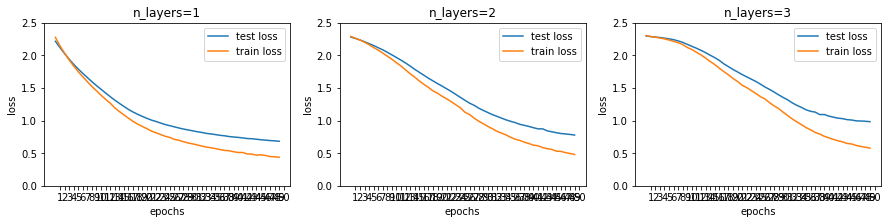

In [7]:
import json
data = []
for i in range(max_hid_layers):
    with open('result' + str(i+1)+ '/log') as data_file:    
        data.append(json.load(data_file))
    
train_losses = [[data[i][j]["main/loss"] for j in range(n_epochs)] for i in range(max_hid_layers)]
test_losses = [[data[i][j]["validation/main/loss"] for j in range(n_epochs)] for i in range(max_hid_layers)]

f, axes = plt.subplots(1, max_hid_layers, sharey=True, figsize=(5 * max_hid_layers, 3))
for i in range(max_hid_layers):
    plt.subplot(1, max_hid_layers, i+1)
    plt.plot(test_losses[i])
    plt.plot(train_losses[i])
    plt.legend(["test loss", "train loss"])
    plt.title("n_layers=" + str(i+1))
    plt.ylabel("loss")
    plt.xlabel("epochs")
    
    # to enforce same yticks for all plots
    ls = np.linspace(0, 2.5, 6)
    plt.yticks(ls)
    # to enforce integer xticks
    eps = np.linspace(1, n_epochs, n_epochs)
    _ = plt.xticks(eps)

It appears that the larger networks do worse, which is counterintuitive. This could however be explained by the fact that the larger networks need to tune more nodes to the right values. Perhaps this could be remedied with additional training epochs and/or more data.

### 2. Create a network consisting of a convolutional layer, a max pooling layer and one fully connected layer. For the convolutional layers, use 5 output channels, a kernel size of 5, stride of 1 and padding of 0. Again plot the loss. Report your conclusions. For background on convolutions please consult: https://github.com/vdumoulin/conv_arithmetic

Our model is defined as follows:

In [8]:
class CNN(Chain):
    def __init__(self, n_units, n_out, activation="sigmoid", dropout=False, batch_norm=False):
        
        self.activation = activation
        self.dropout = dropout
        self.batch_norm = batch_norm
        
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(in_channels=1, 
                                        out_channels=5, 
                                        ksize=5, 
                                        stride=1, 
                                        pad=0)
            if self.batch_norm: 
                self.bn = L.BatchNormalization(5)
            self.fc = L.Linear(None, n_out)
        
            
    def __call__(self, x):
        x = self.conv(x)
        if self.dropout:
            x = F.dropout(x, ratio=0.4)
        if self.activation == "relu":
            h = F.relu(x)
        elif self.activation == "sigmoid":
            h = F.sigmoid(x)
        else:
            print("Activation function not supported!")
        h = F.max_pooling_2d(h, 2, 2)
        if self.batch_norm: 
            h = self.bn(h)
        with chainer.using_config('train', True):
            if self.dropout:
                h = F.dropout(h, ratio=0.4)
            return self.fc(h)
        return F.softmax(self.fc(h))

We need a different data format for the convolutional network, hence we need to get the data again and recreate the iterators.

In [9]:
train_conv, test_conv = get_mnist(n_dim=3)

train_iter_conv = chainer.iterators.SerialIterator(train_conv, batchsize)
test_iter_conv = chainer.iterators.SerialIterator(test_conv, batchsize,
                                             repeat=False, 
                                             shuffle=False)

train_count_conv = len(train_conv)
test_count_conv = len(test_conv)

This time the training procedure is a custom loop.

In [10]:
def train_CNN(train_iter_conv, test_iter_conv, model, n_epochs, train_count, test_count):
    optimizer = chainer.optimizers.SGD()
    optimizer.setup(model)
    
    train_iter_conv.reset()
    test_iter_conv.reset()

    train_losses = []
    test_losses = []

    sum_accuracy = 0
    sum_loss = 0

    while train_iter_conv.epoch < n_epochs:
        batch = train_iter_conv.next()

        x_array, t_array = convert.concat_examples(batch, -1)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        optimizer.update(model, x, t)
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)

        if train_iter_conv.is_new_epoch:
            print('epoch: ', train_iter_conv.epoch)
            train_loss = sum_loss / train_count
            train_losses.append(train_loss)
            print('train mean loss: {}, accuracy: {}'.format(
                  train_loss, sum_accuracy / train_count))

            sum_accuracy = 0
            sum_loss = 0
            model.predictor.train = False
            for batch in test_iter_conv:
                x_array, t_array = convert.concat_examples(batch, -1)
                x = chainer.Variable(x_array)
                t = chainer.Variable(t_array)
                loss = model(x, t)
                sum_loss += float(loss.data) * len(t.data)
                sum_accuracy += float(model.accuracy.data) * len(t.data)

            test_iter_conv.reset()
            model.predictor.train = True
            test_loss = sum_loss / test_count
            test_losses.append(test_loss)
            print('test mean  loss: {}, accuracy: {}'.format(
                  test_loss, sum_accuracy / test_count))
            sum_accuracy = 0
            sum_loss = 0
            
    return train_losses, test_losses

In [11]:
train_losses_def, test_losses_def = train_CNN(train_iter_conv, test_iter_conv, 
                                                L.Classifier(CNN(n_units, 10)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 2.39564766693, accuracy: 0.085
test mean  loss: 2.30158655548, accuracy: 0.079
('epoch: ', 2)
train mean loss: 2.28604159546, accuracy: 0.1
test mean  loss: 2.28391250801, accuracy: 0.121
('epoch: ', 3)
train mean loss: 2.25879853058, accuracy: 0.13
test mean  loss: 2.25689768219, accuracy: 0.175
('epoch: ', 4)
train mean loss: 2.23647902679, accuracy: 0.166
test mean  loss: 2.23939611435, accuracy: 0.217
('epoch: ', 5)
train mean loss: 2.2860431366, accuracy: 0.214
test mean  loss: 2.22038662148, accuracy: 0.128
('epoch: ', 6)
train mean loss: 2.18270093536, accuracy: 0.241
test mean  loss: 2.19132884598, accuracy: 0.289
('epoch: ', 7)
train mean loss: 2.15594796753, accuracy: 0.321
test mean  loss: 2.16679803467, accuracy: 0.328
('epoch: ', 8)
train mean loss: 2.1207516861, accuracy: 0.354
test mean  loss: 2.13064173889, accuracy: 0.429
('epoch: ', 9)
train mean loss: 2.1490408783, accuracy: 0.41
test mean  loss: 2.10312757874, accuracy: 0.483
('epoch:

Next, we plot the loss for the CNN.

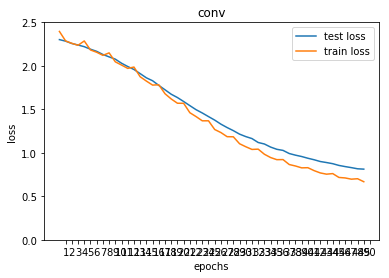

In [12]:
plt.plot(test_losses_def)
plt.plot(train_losses_def)
plt.legend(["test loss", "train loss"])
plt.title("conv")
plt.ylabel("loss")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

Again, one would be tempted to say a CNN would perform much better on this task (in this instance, it doesn't), though perhaps the issue is the same as above, i.e. not enough training time.

### 3. Explain in which ways convolution is biologically plausible and biologically implausible.

In a whole visual frame, pixels that are closer together are usually more correlated than pixels that are far apart. 
In the convolutional layer, individual neurons are only influenced by their local receptive fields. This is much like it happens in the brain, where small regions of the visual field are processed together.

On the other hand, convolutional layers share weights (i.e. each filter is replicated across the entire visual field). In the brain, those weights are implemented in the form of synaptic connections. 
> Synaptic weights are stored in the local physical configuration of each synapse/cell (e.g. the density of various receptors and ion channels).
> -- [user20160, Comment on thread: "To what extent are convolutional neural networks inspired 
by biology?"][1]

Those configurations may not be completely 
different, but they will not be completely the same either. 

[1]:https://stats.stackexchange.com/questions/268793/to-what-extent-are-convolutional-neural-networks-inspired-by-biology#comment513891_268793

### 4. Read the Chainer documentation. Add additional components to your model (e.g. one of dropout, batch normalization, other activation functions, etc.). Report if your new architecture outperforms the original convnet architecture. Provide a plot and a written explanation of your observed (better/worse) results.

First, we train the models with different components.

In [13]:
train_losses_relu, test_losses_relu = train_CNN(train_iter_conv, test_iter_conv, 
                                                L.Classifier(CNN(n_units, 10, 
                                                                 activation="relu")), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 2.19210581207, accuracy: 0.267
test mean  loss: 1.91074273491, accuracy: 0.491
('epoch: ', 2)
train mean loss: 1.61617948151, accuracy: 0.646
test mean  loss: 1.49397986984, accuracy: 0.66
('epoch: ', 3)
train mean loss: 1.18574050903, accuracy: 0.746
test mean  loss: 1.17140353584, accuracy: 0.716
('epoch: ', 4)
train mean loss: 0.904177751541, accuracy: 0.785
test mean  loss: 0.963249237061, accuracy: 0.748
('epoch: ', 5)
train mean loss: 0.751877812386, accuracy: 0.837
test mean  loss: 0.835756890774, accuracy: 0.774
('epoch: ', 6)
train mean loss: 0.6311177845, accuracy: 0.835
test mean  loss: 0.763924828529, accuracy: 0.777
('epoch: ', 7)
train mean loss: 0.561317667007, accuracy: 0.841
test mean  loss: 0.693593714714, accuracy: 0.8
('epoch: ', 8)
train mean loss: 0.520679964066, accuracy: 0.855
test mean  loss: 0.660784873247, accuracy: 0.804
('epoch: ', 9)
train mean loss: 0.497481238365, accuracy: 0.889
test mean  loss: 0.633204932213, accuracy: 

In [14]:
train_losses_dropout, test_losses_dropout = train_CNN(train_iter_conv, test_iter_conv, 
                                                      L.Classifier(CNN(n_units, 10, 
                                                                       dropout=True)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 2.49693021393, accuracy: 0.1
test mean  loss: 2.40379148483, accuracy: 0.107
('epoch: ', 2)
train mean loss: 2.35091499329, accuracy: 0.141
test mean  loss: 2.39251290894, accuracy: 0.113
('epoch: ', 3)
train mean loss: 2.34524394226, accuracy: 0.122
test mean  loss: 2.34305630493, accuracy: 0.116
('epoch: ', 4)
train mean loss: 2.33917517853, accuracy: 0.117
test mean  loss: 2.3440968132, accuracy: 0.131
('epoch: ', 5)
train mean loss: 2.36870867157, accuracy: 0.141
test mean  loss: 2.3154852066, accuracy: 0.128
('epoch: ', 6)
train mean loss: 2.23989961243, accuracy: 0.174
test mean  loss: 2.29880730438, accuracy: 0.142
('epoch: ', 7)
train mean loss: 2.21480554962, accuracy: 0.162
test mean  loss: 2.26145497322, accuracy: 0.168
('epoch: ', 8)
train mean loss: 2.17656952667, accuracy: 0.191
test mean  loss: 2.22929566383, accuracy: 0.17
('epoch: ', 9)
train mean loss: 2.2175026474, accuracy: 0.219
test mean  loss: 2.17947405815, accuracy: 0.218
('epoch

In [15]:
train_losses_relu_dropout, test_losses_relu_dropout = train_CNN(train_iter_conv, test_iter_conv, 
                                                                L.Classifier(CNN(n_units, 10, 
                                                                                 activation="relu", dropout=True)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 2.29881399155, accuracy: 0.202
test mean  loss: 2.00869453144, accuracy: 0.3
('epoch: ', 2)
train mean loss: 1.69364910126, accuracy: 0.45
test mean  loss: 1.58811138344, accuracy: 0.502
('epoch: ', 3)
train mean loss: 1.31171601486, accuracy: 0.58
test mean  loss: 1.28964038372, accuracy: 0.582
('epoch: ', 4)
train mean loss: 0.998665075302, accuracy: 0.69
test mean  loss: 1.09879811478, accuracy: 0.643
('epoch: ', 5)
train mean loss: 0.886415035248, accuracy: 0.75
test mean  loss: 0.966837906837, accuracy: 0.69
('epoch: ', 6)
train mean loss: 0.751472621918, accuracy: 0.761
test mean  loss: 0.929015059471, accuracy: 0.708
('epoch: ', 7)
train mean loss: 0.712632659912, accuracy: 0.766
test mean  loss: 0.903065510273, accuracy: 0.704
('epoch: ', 8)
train mean loss: 0.676946994781, accuracy: 0.768
test mean  loss: 0.834179222584, accuracy: 0.718
('epoch: ', 9)
train mean loss: 0.643952827454, accuracy: 0.811
test mean  loss: 0.81601333642, accuracy: 0.73

In [16]:
train_losses_bn, test_losses_bn = train_CNN(train_iter_conv, test_iter_conv, 
                                              L.Classifier(CNN(n_units, 10, 
                                                               batch_norm=True)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 1.5844731884, accuracy: 0.505
test mean  loss: 1.27181789589, accuracy: 0.595
('epoch: ', 2)
train mean loss: 0.814341732979, accuracy: 0.772
test mean  loss: 0.981581760406, accuracy: 0.702
('epoch: ', 3)
train mean loss: 0.618182261467, accuracy: 0.815
test mean  loss: 0.856568017006, accuracy: 0.736
('epoch: ', 4)
train mean loss: 0.514175749779, accuracy: 0.86
test mean  loss: 0.77697280407, accuracy: 0.765
('epoch: ', 5)
train mean loss: 0.463103665829, accuracy: 0.9
test mean  loss: 0.719660830498, accuracy: 0.777
('epoch: ', 6)
train mean loss: 0.398916830063, accuracy: 0.886
test mean  loss: 0.696763832092, accuracy: 0.785
('epoch: ', 7)
train mean loss: 0.365195726395, accuracy: 0.901
test mean  loss: 0.670334400177, accuracy: 0.794
('epoch: ', 8)
train mean loss: 0.333979471684, accuracy: 0.909
test mean  loss: 0.645948157787, accuracy: 0.803
('epoch: ', 9)
train mean loss: 0.316948841095, accuracy: 0.946
test mean  loss: 0.635948289871, accura

In [17]:
train_losses_relu_bn, test_losses_relu_bn = train_CNN(train_iter_conv, test_iter_conv, 
                                                      L.Classifier(CNN(n_units, 10,
                                                                       activation="relu",
                                                                       batch_norm=True)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 1.7092870903, accuracy: 0.475
test mean  loss: 1.2385667963, accuracy: 0.621
('epoch: ', 2)
train mean loss: 0.735321840286, accuracy: 0.794
test mean  loss: 0.915364153862, accuracy: 0.703
('epoch: ', 3)
train mean loss: 0.52411534214, accuracy: 0.853
test mean  loss: 0.783086539268, accuracy: 0.748
('epoch: ', 4)
train mean loss: 0.414861782074, accuracy: 0.891
test mean  loss: 0.706757586002, accuracy: 0.769
('epoch: ', 5)
train mean loss: 0.357361521244, accuracy: 0.935
test mean  loss: 0.649353373528, accuracy: 0.796
('epoch: ', 6)
train mean loss: 0.299139309406, accuracy: 0.923
test mean  loss: 0.614240038872, accuracy: 0.805
('epoch: ', 7)
train mean loss: 0.264208617687, accuracy: 0.93
test mean  loss: 0.587615334988, accuracy: 0.804
('epoch: ', 8)
train mean loss: 0.236757838726, accuracy: 0.937
test mean  loss: 0.563158563137, accuracy: 0.813
('epoch: ', 9)
train mean loss: 0.219344128132, accuracy: 0.973
test mean  loss: 0.536614414215, accur

In [18]:
train_losses_relu_bn_dropout, test_losses_relu_bn_dropout = train_CNN(train_iter_conv, test_iter_conv, 
                                                                      L.Classifier(CNN(n_units, 10,
                                                                                   activation="relu",
                                                                                   batch_norm=True)), n_epochs, train_count_conv, test_count_conv)

('epoch: ', 1)
train mean loss: 1.59256459236, accuracy: 0.523
test mean  loss: 1.11992480278, accuracy: 0.666
('epoch: ', 2)
train mean loss: 0.760929379463, accuracy: 0.789
test mean  loss: 0.871140538216, accuracy: 0.737
('epoch: ', 3)
train mean loss: 0.564398714066, accuracy: 0.841
test mean  loss: 0.74981371665, accuracy: 0.778
('epoch: ', 4)
train mean loss: 0.471329494476, accuracy: 0.862
test mean  loss: 0.686264006138, accuracy: 0.788
('epoch: ', 5)
train mean loss: 0.417426900864, accuracy: 0.913
test mean  loss: 0.63731031251, accuracy: 0.807
('epoch: ', 6)
train mean loss: 0.358879277229, accuracy: 0.896
test mean  loss: 0.607516822815, accuracy: 0.821
('epoch: ', 7)
train mean loss: 0.327554843903, accuracy: 0.904
test mean  loss: 0.578334963083, accuracy: 0.823
('epoch: ', 8)
train mean loss: 0.295310465813, accuracy: 0.916
test mean  loss: 0.554169712305, accuracy: 0.838
('epoch: ', 9)
train mean loss: 0.280893922567, accuracy: 0.956
test mean  loss: 0.544273186684, acc

Finally, we plot the results.

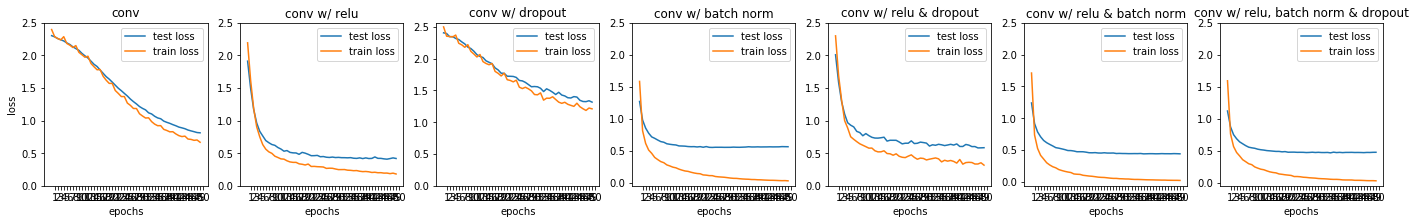

In [19]:
f, axes = plt.subplots(1, 7, sharey=True, figsize=(6 * 4, 3))

plt.subplot(1, 7, 1)
plt.plot(test_losses_def)
plt.plot(train_losses_def)
plt.legend(["test loss", "train loss"])
plt.title("conv")
plt.ylabel("loss")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 2)
plt.plot(test_losses_relu)
plt.plot(train_losses_relu)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ relu")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 3)
plt.plot(test_losses_dropout)
plt.plot(train_losses_dropout)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ dropout")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 4)
plt.plot(test_losses_bn)
plt.plot(train_losses_bn)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ batch norm")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 5)
plt.plot(test_losses_relu_dropout)
plt.plot(train_losses_relu_dropout)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ relu & dropout")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 6)
plt.plot(test_losses_relu_bn)
plt.plot(train_losses_relu_bn)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ relu & batch norm")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

plt.subplot(1, 7, 7)
plt.plot(test_losses_relu_bn_dropout)
plt.plot(train_losses_relu_bn_dropout)
plt.legend(["test loss", "train loss"])
plt.title("conv w/ relu, batch norm & dropout")
plt.xlabel("epochs")
# to enforce same yticks for all plots
ls = np.linspace(0, 2.5, 6)
plt.yticks(ls)
# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)

It appears that changing the activation function to ReLU has the biggest impact. One would need more training epochs to see whether the regularization from dropout has the intended effect. Batch normalization doesn't seem to perform well in this instance. 